In [1]:
# Modelinging homogeneity data 
import pandas as pd
import numpy as np
filepath = "homo_sel.csv"
data_homo = pd.read_csv(filepath)
if 'Unnamed: 0' in data_homo.columns:
    data_homo = data_homo.drop(['Unnamed: 0'],axis=1)   
#print(data_homo.head(10))

Reading data from file

In [2]:
C_h,radius_h,angle_h = np.histogram2d(data_homo['radius'],data_homo['angle'],bins=[np.arange(0,26,1),np.arange(0,365,5)])
angle_h = np.delete(angle_h,-1)
radius_h = np.delete(radius_h,-1)
angle_c = [i + 2.5 for i in angle_h]
radius_c = [i + .5 for i in radius_h]
C_h_t,radius_h_t,angle_h_t = np.histogram2d(data_homo['radius'],data_homo['angle'],bins=[np.arange(0,26,1),np.arange(-2.5,365,5)])
angle_h_t = np.delete(angle_h_t,-1)
radius_h_t = np.delete(radius_h_t,-1)
angle_c_t = [i + 2.5 for i in angle_h_t]
radius_c_t = [i + .5 for i in radius_h_t]
#print(angle_h_t)
print(len(angle_c))
#print(len(radius_c))
pos_x = []
pos_y = []
C_c = []
for i in range(len(radius_c)):
    C_h_t[i][0] = C_h_t[i][72]+ C_h_t[i][0]
    for j in range(len(angle_c)):
        pos_x.append(radius_c[i]*np.cos(angle_c[j]*np.pi/180))
        pos_y.append(radius_c[i]*np.sin(angle_c[j]*np.pi/180))
        C_c.append(C_h[i][j])
pos_h = np.stack((pos_x,pos_y),axis=-1)
angle_c = np.concatenate((angle_c,angle_c_t),axis = None)
C_t = np.concatenate((C_h[5],C_h_t[5]),axis=None)
print(np.mean(C_c)) #Average count of 1800 areas
print(1/np.sqrt(np.mean(C_c)))
print(np.std(C_c)/np.mean(C_c))
#print(len(pos_x))
#print(C_h[1])

72
51.22666666666667
0.13971786846853534
0.4903867817016568


Making counts of each area corresponding to central positions.

145
Matern(length_scale=6.66, nu=1.5)
-73098.44706782038
0.0017228811273774878


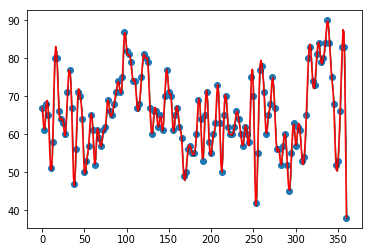

In [4]:
import matplotlib.pyplot as plt
plt.scatter(angle_c,C_t)
#print(len(angle_c))
angle_c_f = np.atleast_2d(angle_c).T
print(len(angle_c_f))
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RBF,WhiteKernel
xx, yy = np.meshgrid(np.linspace(-25, 25, 50),
                     np.linspace(-25, 25, 50))
pos_all = np.vstack((xx.ravel(), yy.ravel()))
x = np.linspace(0, 360, 360)
#kernel_a = RBF(length_scale=1.0)
kernel_a = Matern()
clf_a = GaussianProcessRegressor(kernel=kernel_a,n_restarts_optimizer=9).fit(angle_c_f,C_t)
C_pred,sigma_pred = clf_a.predict(np.atleast_2d(x).T,return_std=True)
C_pred = C_pred.reshape(x.shape)
#sigma_pred = sigma_pred.reshape(xx.shape)0

print(clf_a.kernel_)
#print(clf_a.alpha_)
print(clf_a.log_marginal_likelihood_value_)
print(sigma_pred[1]/C_pred[1])
plt.plot(x, C_pred, 'r-', label='Prediction')
plt.fill_between(x, C_pred - sigma_pred,
                 C_pred + sigma_pred,
                 alpha=0.5, color='k')
plt.show()

One dimensional GP is implemented to model counts versus angles. Very good result.
Next step is to do two dimensional gaussain process in XY- coordinate.

432
Matern(length_scale=1.25, nu=1.5)


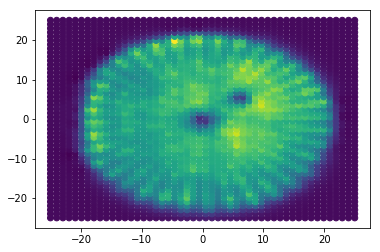

In [5]:
kernel_2d = Matern()#+RBF()
#print(len(pos_h))
print(len(C_c))
clf_2d = GaussianProcessRegressor(kernel=kernel_2d,n_restarts_optimizer=9).fit(pos_h,C_c)
C_2d_pred,std_2d_pred = clf_2d.predict(pos_all.T,return_std=True)
print(clf_2d.kernel_)
#print(C_2d_pred)
#print(std_2d_pred)
plt.scatter(pos_all.T[:,0],pos_all.T[:,1],c=C_2d_pred)
plt.show()

[4.59183673 0.51020408]
246.1475482352471
0.2486769545038599
[16.48429566  0.71971989]
273.0


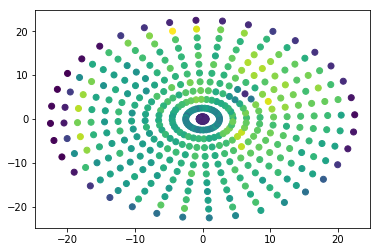

In [6]:
print(pos_all.T[1279])
print(C_2d_pred[1279])
print(std_2d_pred[1279])
plt.scatter(pos_h[:,0],pos_h[:,1],c=C_c)
print(pos_h[288])
print(C_c[288])
plt.show()

After modeling, it is time to check the consistency between experimental data (Blue dots) and predictions (red dots) for radius of 11mm.

2500
-25.0


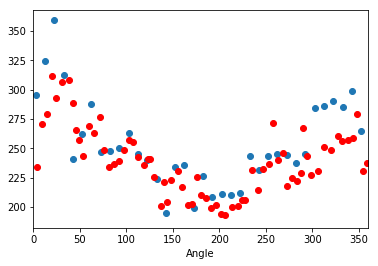

In [10]:
x_center = 0.909
y_center = -1.364
pos_gp = []
C_pred_f = []
pos_s =[]
for i in range(len(pos_all.T)):
    if pos_all.T[i][1]-y_center >0:
        angle_tem = np.arctan2(pos_all.T[i][1]-y_center, pos_all.T[i][0]-x_center)*180/np.pi
    else:
        angle_tem = np.arctan2(pos_all.T[i][1]-y_center, pos_all.T[i][0]-x_center)*180/np.pi + 360
    radius_tem = np.sqrt(np.square(pos_all.T[i][1]-y_center)+np.square(pos_all.T[i][0]-x_center))
    pos_gp.append([radius_tem,angle_tem])
    if radius_tem > 11 and radius_tem <12:
        pos_s.append(angle_tem)
        C_pred_f.append(C_2d_pred[i])
#print(pos_gp)
plt.scatter(angle_c,C_h[5])
print(len(pos_all.T))
print(pos_all.T[1][1])
plt.scatter(pos_s,C_pred_f,c='r')
plt.xlim(0,360)
plt.xlabel("Angle")
plt.show()

GP reproduces the function very well. But we can get the counts of each area, what we really care is the uncertainty. GP gives a very samll error. It is right based on the histogram. Once we cut the data into samll area, each area is independent and whose count follows Poisson distribution. The count is only determined by the size of area. The uncertainty from GP is only error of fitting. If we want to use the result from GP, both of √N and uncertainty of fitting should be taken into account.